# Problem Set 2

## Problem 1

## Load Data Using SQL request

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [ ]:

import wrds
db=wrds.Connection(wrds_username='perusset')

# Get Tickers
tickers = db.raw_sql("select  cusip, tic from comp.funda where tic in ('TSLA','GME','PG','AAPL','GE')").drop_duplicates()
tickers['cusip'] = tickers['cusip'].str[:-1]
print(tickers['cusip'].to_list())


Enter your WRDS username [perusset]:perusset
Enter your password:········


In [64]:
#tickers

In [25]:
# Load Stock Data

stocks = db.raw_sql("select  date,cusip,ret from crsp.dsf where cusip in ('03783310', '36960430', '36467W10', '74271810', '88160R10') and date>='2000-01-01' and date<='2023-12-31'")
stocks = pd.merge(stocks, tickers, on=['cusip'], how='left')
stocks = stocks.set_index(['date','tic'])['ret'].unstack('tic')
stocks.reset_index().to_csv('Returns_Stocks.csv', sep=';', index=False)


In [19]:
# Import data (only in case you have troubles with WRDS)
stocks=pd.read_csv("Returns_Stocks.csv", sep=';',index_col='date')
print(stocks)

                AAPL        GE       GME        PG      TSLA
date                                                        
2000-01-03  0.088754 -0.030695       NaN -0.021677       NaN
2000-01-04 -0.084310 -0.038750       NaN -0.019242       NaN
2000-01-05  0.014634 -0.005202       NaN -0.019025       NaN
2000-01-06 -0.086539  0.015577       NaN  0.046061       NaN
2000-01-07  0.047368  0.038721       NaN  0.079954       NaN
...              ...       ...       ...       ...       ...
2023-12-22 -0.005548 -0.002205 -0.000589  0.007071 -0.007701
2023-12-26 -0.002841  0.006157  0.022982  0.004543  0.016116
2023-12-27  0.000518  0.006354  0.058180  0.000822  0.018822
2023-12-28  0.002226  0.000936 -0.016331 -0.002259 -0.031594
2023-12-29 -0.005424 -0.005377 -0.029884  0.005558 -0.018564

[6037 rows x 5 columns]


In [20]:
# Winsorize Stock Data
S=['AAPL','TSLA','GME','PG','GE']
stocks_win = stocks.copy()
for s in S:
    stocks_win.loc[np.abs(stocks_win[s])>=0.04,s] = np.nan

In [21]:
from scipy.stats import norm
#(a) Compute the empirical mean and variance of returns
df_stats = pd.DataFrame({'Mean' : stocks[S].mean(), 
                       'Variance' : stocks[S].var(),
                       'Wind.Mean' : stocks_win.mean(),
                       'Wind.Variance' : stocks_win.var()
                      })
print('\n Simple and windsorized mean and variance:')
display(df_stats)


 Simple and windsorized mean and variance:


,Mean,Variance,Wind.Mean,Wind.Variance
AAPL,0.001233,0.000613,0.000879,0.000257
GE,0.000172,0.000440,0.000040,0.000204
GME,0.001560,0.002556,0.000049,0.000326
PG,0.000359,0.000178,0.000391,0.000109
TSLA,0.002126,0.001285,0.000993,0.000349


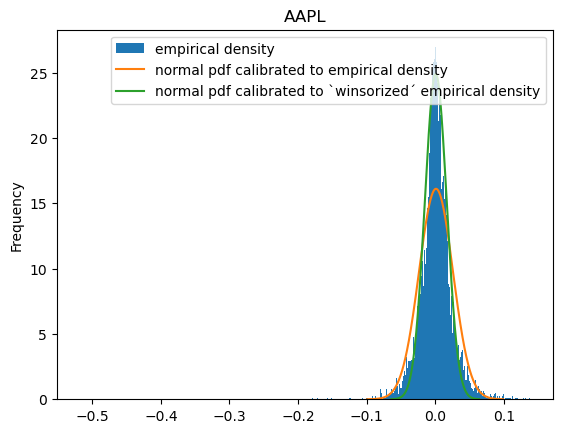

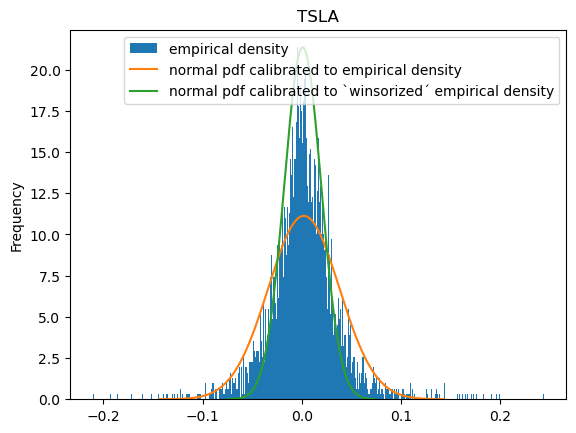

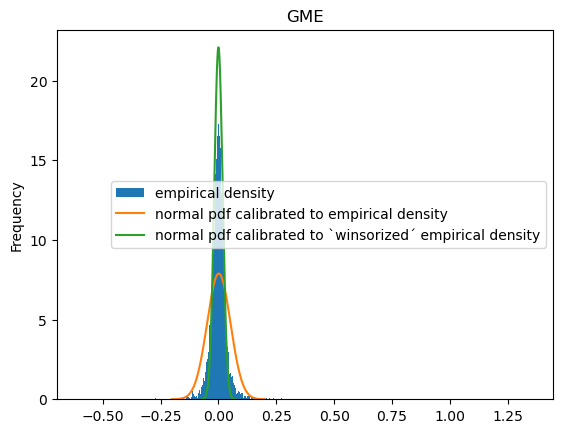

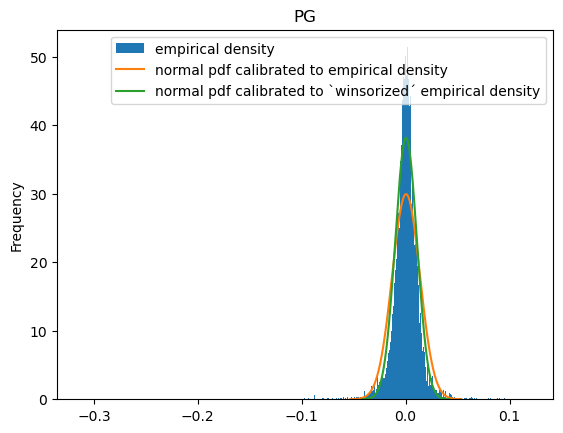

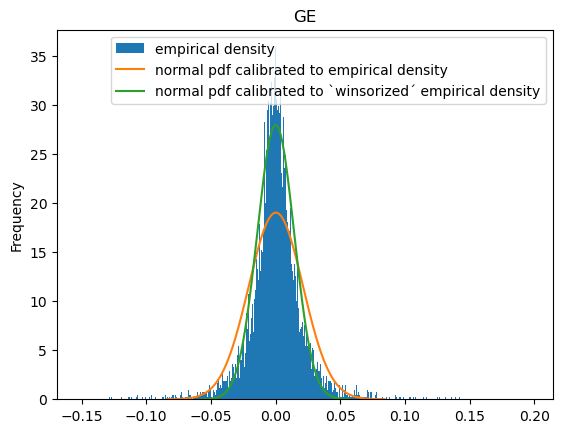

In [22]:
#Define the normal pdf
def normdens(x,m,s2):
    return np.exp(-0.5*(x-m)**2/s2)/np.sqrt(2*np.pi*s2)

# (b)Compute the empirical distribution function for each stock
for s in S:
    stocks[s].plot.hist(bins=500,density=True,label='empirical density')
    x=np.linspace(-4*np.sqrt(df_stats.loc[s]['Variance']),+4*np.sqrt(df_stats.loc[s]['Variance']),500)
    y=normdens(x,df_stats.loc[s]['Mean'],df_stats.loc[s]['Variance'])
    plt.plot(x,y,label='normal pdf calibrated to empirical density')
    
    x=np.linspace(-4*np.sqrt(df_stats.loc[s]['Wind.Variance']),+4*np.sqrt(df_stats.loc[s]['Wind.Variance']),500)
    y=normdens(x,df_stats.loc[s]['Wind.Mean'],df_stats.loc[s]['Wind.Variance'])
    plt.plot(x,y,label='normal pdf calibrated to `winsorized´ empirical density')
    plt.title(s)
    plt.legend()
    plt.show()

In [23]:
# C) Compute the 95% and 99% VaR
VaR = pd.DataFrame({'95%' : stocks.quantile(0.05), 
                    '99%' : stocks.quantile(0.01),
                    '95% Normal' : norm.ppf(0.05, df_stats['Mean'], np.sqrt(df_stats['Variance'])), 
                    '99% Normal' : norm.ppf(0.01, df_stats['Mean'], np.sqrt(df_stats['Variance'])) 
                      })
print('\n 95% VaR and 99% Var (empirical + normal r.v. with moments matched to empirical distribution):')
display(VaR.style.format("{:.2%}"))


 95% VaR and 99% Var (empirical + normal r.v. with moments matched to empirical distribution):


,95%,99%,95% Normal,99% Normal
AAPL,-3.64%,-6.33%,-3.95%,-5.64%
GE,-3.10%,-5.93%,-3.43%,-4.86%
GME,-5.13%,-10.74%,-8.16%,-11.61%
PG,-1.76%,-3.49%,-2.16%,-3.06%
TSLA,-5.10%,-9.02%,-5.68%,-8.13%


In [24]:
# Compute the 95% and 99% Expected shortfall
VaR95=norm.ppf(0.05, df_stats['Mean'], np.sqrt(df_stats['Variance'])), 
VaR99=norm.ppf(0.01, df_stats['Mean'], np.sqrt(df_stats['Variance'])), 
ES95=df_stats['Mean']-np.sqrt(df_stats['Variance'])*norm.pdf(norm.ppf(0.05,0,1))/norm.cdf(norm.ppf(0.05,0,1))
ES99=df_stats['Mean']-np.sqrt(df_stats['Variance'])*norm.pdf(norm.ppf(0.01,0,1))/norm.cdf(norm.ppf(0.01,0,1))

VaR95emp=stocks.quantile(0.05)
VaR99emp=stocks.quantile(0.01)

ES95_emp = []
ES99_emp = []
for s in S:
    ES95_emp.append(stocks[stocks[s]<VaR95emp[s]][s].mean())
    ES99_emp.append(stocks[stocks[s]<VaR99emp[s]][s].mean())
ES95_emp = pd.Series(ES95_emp, index=S)
ES99_emp = pd.Series(ES99_emp, index=S)

In [25]:
ES = pd.DataFrame({'95%' : ES95_emp, 
                    '99%' : ES99_emp,
                    '95% Normal' : ES95, 
                    '99% Normal' : ES99 
                      })
print('\n 95% ES and 99% ES (empirical + normal r.v. with moments matched to empirical distribution):')
#VaR= VaR.set_index(S)
display(ES.style.format("{:.2%}"))


 95% ES and 99% ES (empirical + normal r.v. with moments matched to empirical distribution):


,95%,99%,95% Normal,99% Normal
AAPL,-5.50%,-9.10%,-4.98%,-6.48%
GE,-4.92%,-8.23%,-4.31%,-5.57%
GME,-8.80%,-17.00%,-10.27%,-13.32%
PG,-3.09%,-5.69%,-2.71%,-3.52%
TSLA,-7.84%,-12.67%,-7.18%,-9.34%


d)
--------------------------------------------------
We notice that the normal distribution 
does not characterize appropriately the distribution 
of daily stock returns.
If we include all returns,
the distribution does not fit well
the center of the distribution:
It overestimates the probability
of moderate moves.
This can also be seen from the fact
that the calibrated normal distribution 
overestimates the 95%-VaR
(but underestimates the 99%-VaR).

On the other hand,
if we winsorize the data
by filtering out the "extreme moves",
we fit well the center of the distribution
but significantly underestimate 
the probability of large moves.
This difficulty arises from the fact that
the distribution of daily stock returns
are characterized by "fat tails":
large daily returns occur much more frequently 
than the normal distribution would predict.

A better model of daily stock returns
would have a "diffusion" part 
(for example, a geometric brownian motion)
which would be calibrated to match
the returns excluding large swings.
Then, we would account separately
for the large but infrequent swings
by adding jumps to the stochastic process.
Such models are called
"jump-diffusion models".

## Problem 2

# a) Mean- standard deviation frontier

$$\mu_p = \mu_{AAPL}w_{AAPL} + (1-w_{AAPL})\mu_{PG}$$ 

$$\sigma_p = \sqrt {w_{AAPL}^2\sigma_{AAPL}^2 + (1-w_{AAPL})^2\sigma_{PG}^2 + 2w_{AAPL}(1-w_{AAPL})\rho\sigma_{AAPL}\sigma_{PG}}$$




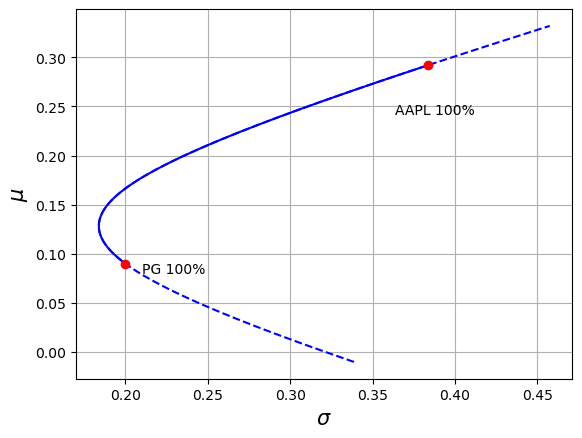

In [26]:
# b) Plot the minimum variance frontier
AAPL_mean = 0.29
AAPL_std = 0.38
PG_mean = 0.09
PG_std = 0.2
corr = 0.1

weight = np.linspace(start=0, stop=1.01, num=1000)
Exp = weight*AAPL_mean+(1-weight)*PG_mean
Std = np.sqrt(weight**2*AAPL_std**2+(1-weight)**2*PG_std**2+2*weight*(1-weight)*corr*AAPL_std*PG_std)

weight_total = np.linspace(start=-0.5, stop=1.21, num=1000)
Exp_total = weight_total*AAPL_mean+(1-weight_total)*PG_mean
Std_total = np.sqrt(weight_total**2*AAPL_std**2+(1-weight_total)**2*PG_std**2+2*weight_total*(1-weight_total)*corr*AAPL_std*PG_std)

plt.plot(Std_total, Exp_total, linestyle='--', c='blue')
plt.plot(Std, Exp, linestyle='-', c='blue')
plt.xlabel('$\sigma$', fontsize=15)
plt.ylabel('$\mu$', fontsize=15)
plt.grid(True)

plt.annotate('AAPL 100%', (Std[-1], Exp[-1]), xytext=(Std[-1]-.02, Exp[-1]-.05))
plt.annotate('PG 100%', (Std[0], Exp[0]), xytext=(Std[0]+.01, Exp[0]-.01))
plt.plot([Std[-1],Std[0]], [Exp[-1],Exp[0]], 'ro')


# c) Global minimum variance portfolio

The composition of the global minimum variance portfolio is:

$$w_{min} = \frac{\Sigma^{-1}e}{e'\Sigma^{-1}e}$$

where $e$ is a $2\times 1$ vector of ones.

In [27]:
#c) Compute global min portfolio

# Numercically 
index = np.argmin(Std) 

# Analytically
mu = np.array([AAPL_mean,PG_mean])
Sigma = np.array([[AAPL_std**2,corr*AAPL_std*PG_std],[corr*AAPL_std*PG_std,PG_std**2]])
e=np.transpose(np.ones(2))
Sigma_inv = np.linalg.inv(Sigma)
w_GMV = Sigma_inv@e/(np.transpose(e)@Sigma_inv@e) 
mu_GMV = np.transpose(mu)@w_GMV
std_GMV = np.sqrt(np.transpose(w_GMV) @ Sigma @ w_GMV)
SR_GMV = (mu_GMV -0.015)/std_GMV

print(f' AAPL Weight: {w_GMV[0]:8.5f}')
print(f' PG Weight: {(1-w_GMV[0]):8.5f}')
print(f' Portfolio mean: {mu_GMV*100:5.2f}%')
print(f' Portfolio std: {std_GMV*100:5.2f}%')
print(f' Sharp Ratio: {SR_GMV:5.2f}')


 AAPL Weight:  0.19149
 PG Weight:  0.80851
 Portfolio mean: 12.83%
 Portfolio std: 18.38%
 Sharp Ratio:  0.62


# d-e) Tangency portfolio

We can show that:

$$w_{tan}=\frac{\Sigma^{-1}(\mu-r_fe)}{e'\Sigma^{-1}(\mu-r_fe)}$$

where $e$ is a  $2\times 1$ vector of ones.

Moreover, we have that the mean-std efficient frontier is given by:

$$\mu_p = r_f + SR_{tan}\sigma_p$$

where $SR_{tan}$ is the Sharpe ratio of the tangency portfolio and $\mu_p$ and $\sigma_p$ are the mean and the standard deviation of the MVE portfolio.

 AAPL Weight:  0.54408
 PG Weight:  0.45592
 Portfolio mean: 19.88%
 Portfolio std: 23.42%
 Sharp Ratio:  0.79


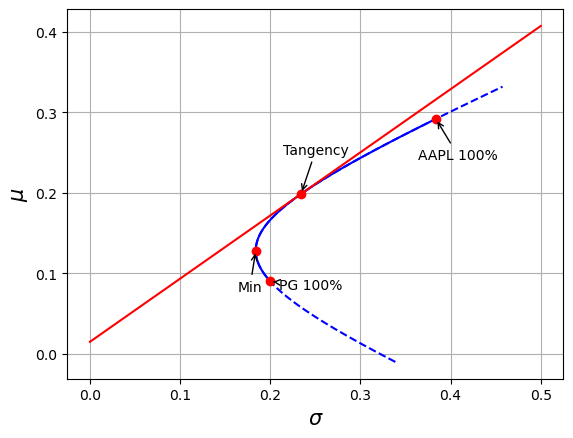

In [28]:
#d-e)Plot of the efficient frontier with a risk-free asset

# Numercially
rf=0.015
S = (Exp-rf)/Std
optimal_Sharp = ((Exp-rf)/Std).max() 
index_tan=np.argmax(S)

# Analytically
w_tan = Sigma_inv@(mu - e*r_f)/(np.transpose(e)@Sigma_inv@(mu - e*r_f))

mu_tan = np.transpose(mu)@w_tan
std_tan = np.sqrt(np.transpose(w_tan) @ Sigma @ w_tan)
SR_tan = (mu_tan -r_f)/std_tan

x= np.linspace(start=0, stop=0.5, num=10000)
y=rf+SR_tan*x

plt.plot(Std_total, Exp_total, linestyle='--', c='blue')
plt.plot(Std, Exp, linestyle='-', c='blue')
plt.plot(x, y, '-r', label='CML')
plt.xlabel('$\sigma$', fontsize=15)
plt.ylabel('$\mu$', fontsize=15)
plt.grid(True)

plt.annotate('AAPL 100%', (Std[-1], Exp[-1]), xytext=(Std[-1]-.02, Exp[-1]-.05), arrowprops=dict(arrowstyle="->"))
plt.annotate('PG 100%', (Std[0], Exp[0]), xytext=(Std[0]+.01, Exp[0]-.01), arrowprops=dict(arrowstyle="->"))
plt.annotate('Min', (Std[index], Exp[index]), xytext=(Std[index]-.02, Exp[index]-.05), arrowprops=dict(arrowstyle="->"))
plt.annotate('Tangency', (Std[index_tan], Exp[index_tan]), xytext=(Std[index_tan]-.02, Exp[index_tan]+.05), arrowprops=dict(arrowstyle="->"))

plt.plot([Std[-1],Std[0], Std[index], Std[index_tan]], [Exp[-1],Exp[0], Exp[index], Exp[index_tan]],  'ro')

print(f' AAPL Weight: {w_tan[0]:8.5f}')
print(f' PG Weight: {(1-w_tan[0]):8.5f}')
print(f' Portfolio mean: {mu_tan*100:5.2f}%')
print(f' Portfolio std: {std_tan*100:5.2f}%')
print(f' Sharp Ratio: {SR_tan:5.2f}')

# f) Target Volatility

$\sigma_{target} = w_{tan} * \sigma_{tan} + (1-w_{tan})\underbrace{\sigma_{rf}}_{=0}$


$w_{tan} = \frac{\sigma_{target}}{\sigma_{tan}}$

In [29]:
#f)
w_tan = 0.2/Std[index_tan]

print(f' w_tan: {(w_tan) :5.2f} ')
w_rf = (1-w_tan)
print(f' w_rf: {(w_rf) :5.2f} ')
w_AAPL = w_tan*weight[index_tan]
print(f' w_AAPL*: {(w_AAPL) :5.2f} ')
w_PG = w_tan*(1-weight[index_tan])
print(f' w_PG*: {(w_PG) :5.2f} ')
alpha = (AAPL_mean-rf)/(w_AAPL*AAPL_std**2+w_PG*corr*AAPL_std*PG_std) # (cf slide 43 of Lecture 1) #alpha = (AAPL_mean-rf)/(w_AAPL*AAPL_std**2+w_PG*corr*AAPL_std*PG_std)
print(f' risk aversion*: {(alpha) :5.2f} ')
mean_p = w_rf*rf+w_AAPL*AAPL_mean+w_PG*PG_mean
print(f' mean_p*: {(mean_p)*100 :5.2f}% ')
#Sharpe ratio remains unchanged since the portfolio is on the CML
print(f' Sharp Ratio: {(Exp[index_tan]-0.015)/Std[index_tan]:5.2f}')


 w_tan:  0.85 
 w_rf:  0.15 
 w_AAPL*:  0.46 
 w_PG*:  0.39 
 risk aversion*:  3.93 
 mean_p*: 17.20% 
 Sharp Ratio:  0.79


# g) Target VaR

Let $x\sim N(r_f + w_{tan}(\mu-rf),w_{tan}\sigma_{tan})$ denote the normally distributed return on the portfolio. 


$\mathbb{P}\big(x<VaR_{99\%}\big) = \mathbb{P}\big(\frac{x-w_{tan}(\mu-r_f)-r_f}{w_{tan}\sigma_{tan}}<\frac{VaR_{99\%}-r_f-w_{tan}(\mu-rf)}{w_{tan}\sigma_{tan}}\big) = \Phi(\frac{VaR_{99\%}-r_f-w_{tan}(\mu-rf)}{w_{tan}\sigma_{tan}})=1\%$


Solving for $w_{tan}$:


$w_{tan} = \frac{VaR_{99}-r_f}{\mu_{tan}-r_f+\sigma_{tan}\Phi^{-1}(1\%)}$


where $\Phi^{-1}(1\%)\approx -2.32$

In [30]:
# g)
w_tan = (-0.1-rf)/(Exp[index_tan]-rf-2.32*Std[index_tan])
w_rf = (1-w_tan)
w_AAPL = w_tan*weight[index_tan]
w_PG = w_tan*(1-weight[index_tan])
alpha = (AAPL_mean-rf)/(w_AAPL*AAPL_std**2+w_PG*corr*AAPL_std*PG_std) # (cf slide 43 of Lecture 1) #alpha = (AAPL_mean-rf)/(w_AAPL*AAPL_std**2+w_PG*corr*AAPL_std*PG_std)
print(f' risk aversion*: {(alpha) :5.2f} ')
print(w_tan)

 risk aversion*: 10.48 
0.32000157412902364
